In [1]:
# Generate data for Huber regression.
srand(1);
n = 300;
SAMPLES = int(1.5*n);
beta_true = 5*randn(n);
X = randn(n, SAMPLES);
Y = zeros(SAMPLES);
v = randn(SAMPLES);

In [ ]:
# Generate data for different values of p.
# Solve the resulting problems.
# WARNING this script takes a few minutes to run.
using Convex, SCS, Distributions
set_default_solver(SCSSolver(verbose=0));
TESTS = 50;
lsq_data = zeros(TESTS);
huber_data = zeros(TESTS);
prescient_data = zeros(TESTS);
p_vals = linspace(0,0.15, TESTS);
for i=1:length(p_vals)
    p = p_vals[i];
    # Generate the sign changes.
    factor = float(2 * rand(Binomial(1, 1-p), SAMPLES) - 1);
    Y = factor .* X' * beta_true + v;
    
    # Form and solve a standard regression problem.
    beta = Variable(n);
    fit = norm(beta - beta_true) / norm(beta_true);
    cost = norm(X' * beta - Y);
    prob = minimize(cost);
    solve!(prob);
    lsq_data[i] = evaluate(fit);
    
    # Form and solve a prescient regression problem,
    # i.e., where the sign changes are known.
    cost = norm(factor .* (X'*beta) - Y);
    solve!(minimize(cost))
    prescient_data[i] = evaluate(fit);
    
    # Form and solve the Huber regression problem.
    cost = sum(huber(X' * beta - Y, 1));
    solve!(minimize(cost))
    huber_data[i] = evaluate(fit);
end

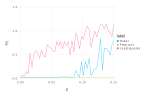

In [3]:
using Gadfly, DataFrames
df = DataFrame(x=p_vals, y=huber_data, label="Huber");
df = vcat(df, DataFrame(x=p_vals, y=prescient_data, label="Prescient"));
df = vcat(df, DataFrame(x=p_vals, y=lsq_data, label="Least squares"));
plot(df, x="x", y="y", color="label", Geom.line, Guide.XLabel("p"), Guide.YLabel("Fit"))

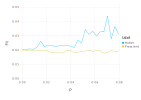

In [4]:
# Plot the relative reconstruction error for Huber and prescient regression,
# zooming in on smaller values of p.
indices = find(p_vals .<= 0.08);
df = DataFrame(x=p_vals[indices], y=huber_data[indices], label="Huber");
df = vcat(df, DataFrame(x=p_vals[indices], y=prescient_data[indices], label="Prescient"));
plot(df, x="x", y="y", color="label", Geom.line, Guide.XLabel("p"), Guide.YLabel("Fit"))